In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [4]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [7]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [8]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [9]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical

In [14]:
## LSTM Model
inputs = Input(shape=(n_timesteps, n_features))
lstm = LSTM(100)(inputs)
dropout = Dropout(0.5)(lstm)
outputs = Dense(n_outputs, activation='softmax')(dropout)

lstm_model = Model(inputs=inputs, outputs=outputs)

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,606 (174.24 KB)

 Trainable params: 44,606 (174.24 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model_history=lstm_model.fit(x=X_train, y=y_train_one_hot, epochs=30, batch_size=32,validation_split=0.1)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.4158 - loss: 1.4125 - val_accuracy: 0.5552 - val_loss: 0.9496
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.6212 - loss: 0.8757 - val_accuracy: 0.7131 - val_loss: 0.6798
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.7484 - loss: 0.6293 - val_accuracy: 0.8489 - val_loss: 0.4112
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.8640 - loss: 0.4089 - val_accuracy: 0.9083 - val_loss: 0.2402
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.8983 - loss: 0.3192 - val_accuracy: 0.9474 - val_loss: 0.1973
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9086 - loss: 0.2958 - val_accuracy: 0.9440 - val_loss: 0.1804
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9323 - loss: 0.2263 - val_accuracy: 0.9406 - val_loss: 0.1691
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9160 - loss: 0.2411 -

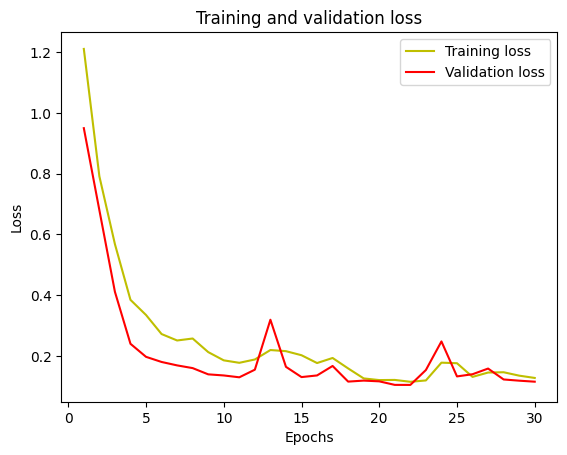

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

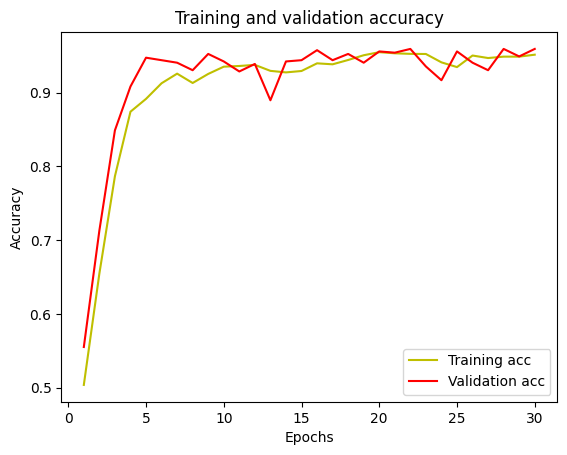

In [17]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step
[[466  26   4   0   0   0]
 [  4 465   2   0   0   0]
 [  5  11 404   0   0   0]
 [  0   2   1 391  97   0]
 [  1   2   0  96 433   0]
 [  0   0   0   1   0 536]]
0.9144893111638955
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       496
           1       0.92      0.99      0.95       471
           2       0.98      0.96      0.97       420
           3       0.80      0.80      0.80       491
           4       0.82      0.81      0.82       532
           5       1.00      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

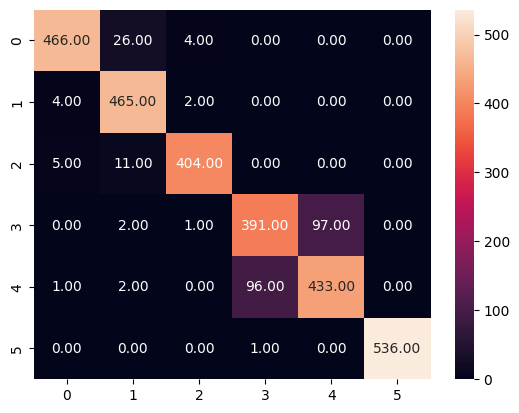

In [18]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=lstm_model.predict(testX)
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')